In [0]:
!pip install easy-vqa

     |████████████████████████████████| 3.2MB 2.8MB/s 


In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers

Using TensorFlow backend.


In [0]:
def build_model(im_shape, vocab_size, num_answers):
  
  # CNN
  im_input = Input(shape=im_shape)
  x1 = Conv2D(8, 3, padding='same')(im_input)
  x1 = MaxPooling2D()(x1)
  x1 = Conv2D(16, 3, padding='same')(x1)
  x1 = MaxPooling2D()(x1)
  x1 = Conv2D(32, 3, padding='same')(x1)
  x1 = MaxPooling2D()(x1)
  x1 = Flatten()(x1)
  img_emb = Dense(32, activation='relu')(x1)

  # Question encoder
  q_input = Input(shape=(vocab_size,))
  x2 = Dense(32, activation='relu')(q_input)
  ques_emb = Dense(32, activation='relu')(x2)

  # Merging the outputs
  out = Multiply()([img_emb, ques_emb])
  out = Dense(32, activation='relu')(out)
  out = Dense(num_answers, activation='softmax')(out)

  model = Model(inputs=[im_input, q_input], outputs=out)
  model.compile(Adam(lr=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [0]:
def setup():
  
  #Reading Questions
  print('\n--- Reading questions...')
  train_qs, train_answers, train_image_ids = get_train_questions()
  test_qs, test_answers, test_image_ids = get_test_questions()
  print(f'Read {len(train_qs)} training questions and {len(test_qs)} testing questions.')

  # Reading Answers 
  print('\n--- Reading answers...')
  all_answers = get_answers()
  num_answers = len(all_answers)
  print(f'Found {num_answers} total answers:')
  print(all_answers)

  
  print('\n--- Reading and pre-processing images...')
  def load_and_proccess_image(image_path):
    # Load image, then scale and shift pixel values to [-0.5, 0.5]
    im = img_to_array(load_img(image_path))
    return im / 255 - 0.5

  def read_images(paths):
    # paths is a dict mapping image ID to image path
    # Returns a dict mapping image ID to the processed image
    ims = {}
    for image_id, image_path in paths.items():
      ims[image_id] = load_and_proccess_image(image_path)
    return ims

  # Reading images 
  train_ims = read_images(get_train_image_paths())
  test_ims = read_images(get_test_image_paths())
  im_shape = train_ims[0].shape
  print(f'Read {len(train_ims)} training images and {len(test_ims)} testing images.')
  print(f'Each image has shape {im_shape}.')


  print('\n--- Fitting question tokenizer...')
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_qs)

  # Adding one because the Keras Tokenizer reserves index 0 and never uses it.
  vocab_size = len(tokenizer.word_index) + 1
  print(f'Vocab Size: {vocab_size}')
  print(tokenizer.word_index)


  # Converting questions to bags of words
  train_X_seqs = tokenizer.texts_to_matrix(train_qs)
  test_X_seqs = tokenizer.texts_to_matrix(test_qs)
  

  # Creating model input images
  train_X_ims = [train_ims[id] for id in train_image_ids]
  test_X_ims = [test_ims[id] for id in test_image_ids]


  # Creating model outputs
  train_answer_indices = [all_answers.index(a) for a in train_answers]
  test_answer_indices = [all_answers.index(a) for a in test_answers]
  train_Y = to_categorical(train_answer_indices)
  test_Y = to_categorical(test_answer_indices)

  return (train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs,
          test_Y, im_shape, vocab_size, num_answers)  

In [0]:
# Preparing the data
train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs, test_Y, im_shape, vocab_size, num_answers = setup()

# Building the model
model = build_model(im_shape, vocab_size, num_answers)
checkpoint = ModelCheckpoint('model_1.h5', save_best_only=True)

print('\n--- Training the model...')
history = model.fit(
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=30,
  callbacks=[checkpoint],
)


--- Reading questions...
Read 38575 training questions and 9673 testing questions.

--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']

--- Reading and pre-processing images...
Read 4000 training images and 1000 testing images.
Each image has shape (64, 64, 3).

--- Fitting question tokenizer...
Vocab Size: 27
{'is': 1, 'shape': 2, 'the': 3, 'a': 4, 'image': 5, 'there': 6, 'not': 7, 'what': 8, 'present': 9, 'does': 10, 'contain': 11, 'in': 12, 'color': 13, 'no': 14, 'circle': 15, 'rectangle': 16, 'triangle': 17, 'brown': 18, 'yellow': 19, 'gray': 20, 'teal': 21, 'black': 22, 'red': 23, 'green': 24, 'blue': 25, 'of': 26}

--- Training the model...
Train on 38575 samples, validate on 9673 samples
Epoch 1/30
38575/38575 [==============================] - 16s 426us/step - loss: 0.8899 - accuracy: 0.6378 - val_loss: 0.7839 - val_accuracy: 0.6611
Epoch 2/30
38575/38575 [=========

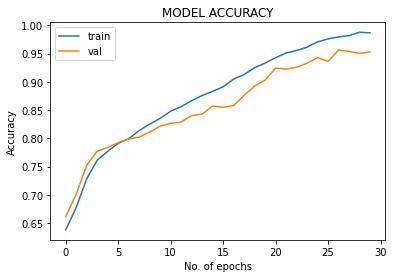

In [0]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('No. of epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

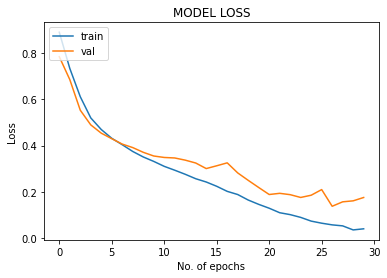

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('Loss')
plt.xlabel('No. of epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()